# # **<center><font style="color:rgb(100,109,254)">Human Action Recognition SVM HMDB51</font> </center>**


In [1]:
# Discard the output of this cell.
# %%capture
# Install the required libraries.
!pip install opencv-contrib-python




## **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

We will start by installing and importing the required libraries.

In [2]:
# Import the required libraries.
import os
import cv2 as cv

import random
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
%matplotlib inline
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

And will set `Numpy`, `Python`, and `Tensorflow` seeds to get consistent results on every execution.


In [3]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)


## **<font style="color:rgb(134,19,348)">Step 1: Visualize the Data with its Labels</font>**


For visualization, we will pick `20` random categories from the dataset and a random video from each selected category and will visualize the first frame of the selected videos with their associated labels written. This way we’ll be able to visualize a subset ( `20` random videos ) of the dataset.

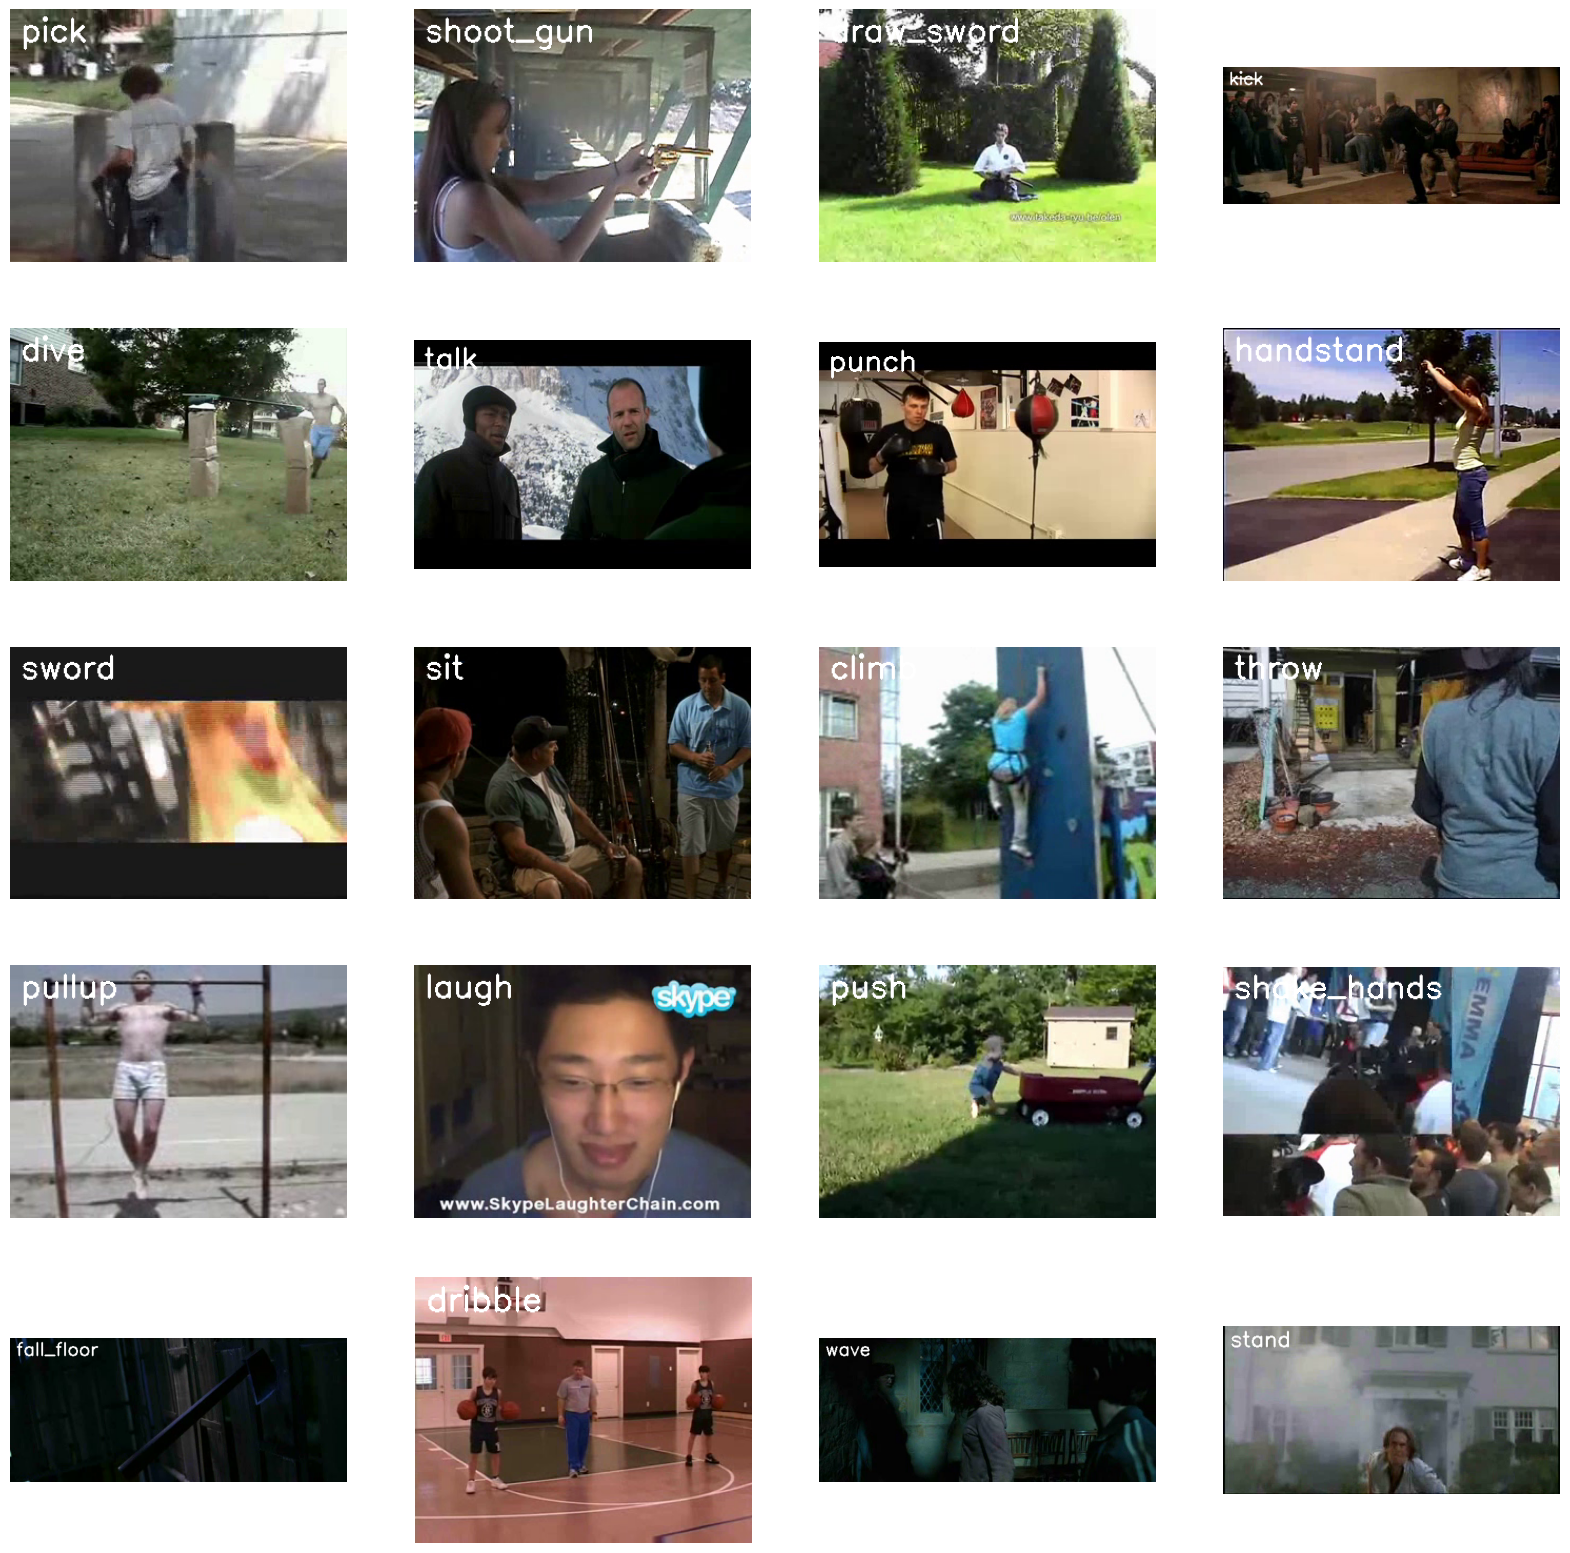

In [4]:
hmdb_root = '/kaggle/input/hmdb51full/hmdb51/hmdb51/'

# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in HMDB51.
all_classes_names = os.listdir(hmdb_root)

# Generate a list of 20 random values. The values will be between 1-51, 
# where 101 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'{hmdb_root}{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv.VideoCapture(f'{hmdb_root}{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object. 
    video_reader.release()

    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv.cvtColor(bgr_frame, cv.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv.putText(rgb_frame, selected_class_Name, (10, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

## **<font style="color:rgb(134,19,348)">Step 2: Preprocessing</font>**



### **<font style="color:rgb(15, 214, 94)">2.1 Create a Function for Dataset Creation</font>**

Now we will create a function **`VideoDataset`** use torch
- *`video_dir`*: Đường dẫn tới thư mục chứa các video (video directory).
- *`trainTest_dir`*: Đường dẫn tới thư mục chứa tệp tin train/test (train/test split txt directory).
- *`classesIdx_txt`*: Đường dẫn tới tệp tin chứa danh sách các nhãn lớp (class index txt directory).
- *`mode`*: Chế độ của dataset, có thể là 'train' hoặc 'test'. Mặc định là 'train'.
- *`num_classes`*: Số lượng lớp cần sử dụng. Mặc định là 5.
- *`num_frames`*: Số lượng khung hình trong mỗi video. Mặc định là 50.
- *`transform`*: Hàm chuyển đổi dữ liệu cho các khung hình. Mặc định là None.
- *`target_transform`*: Hàm chuyển đổi nhãn lớp. Mặc định là None.

In [5]:
def read_video(video_path,num_frames):
        # Proccessing video to frames and transform
    frames = []
    cap = cv.VideoCapture(video_path)#
    count_frames = 0
    while True:
        ret, frame = cap.read()
        if ret:
            res=cv.resize(frame,(64,64))
            res = cv.cvtColor(res, cv.COLOR_BGR2GRAY)
            frames.append(res)
            count_frames += 1
        else: 
            break
    stride = count_frames // num_frames
    if stride ==0:
        print(video_path)
        return []
    else: 
        new_frames = []
        count = 0
        for i in range(0, count_frames, stride):
            if count >= num_frames:
                break
    
            res=hog(frames[i],orientations=4,pixels_per_cell=(8,8),visualize=False,cells_per_block=(2,2))
            new_frames.append(res)
            count += 1

        cap.release()
          
        return new_frames  

def create_dataset(video_dir, trainTest_dir, classesIdx_txt, num_classes = 30,
                     num_frames = 30, target_transform = None):   
    class_dict = {}
    with open(classesIdx_txt, 'r') as f:
        for line in f.readlines():
            classIdx, classLabel = line.split()
            class_dict[int(classIdx)] = classLabel
    
    labels=[]
    images=[]
    video_filename_list = []
    classesIdx_list = []
    with open(trainTest_dir, 'r') as f:
        for line in f.readlines():
            filename, Idx = line.split()
            if int(Idx) <= num_classes:
                video_filename_list.append(filename)
                classesIdx_list.append(int(Idx))
                
    for idx in range(len(video_filename_list)):
        classIdx = classesIdx_list[idx]
        classLabel = class_dict[classIdx]
        video_filename = video_filename_list[idx]
        video_path = os.path.join(video_dir, video_filename)
            
        frames = read_video(video_path,num_frames)
        for fr in frames:
            images.append(fr)
            labels.append(classIdx - 1)
        
    return np.array(images, dtype='float32'), np.array(labels, dtype='int8')

### **<font style="color:rgb(15, 214, 94)">Step 2.2: Initialize Variable</font>** 

In [6]:
classesIdx_txt = '/kaggle/input/hmdb51full/hmdb51all_label/hmdb_labels.txt'
trainTest_dir = '/kaggle/input/hmdb51full/videolist.txt'
mode = 'train'
video_dir = '/kaggle/input/hmdb51full/hmdb51/hmdb51'
# best_weights = 'best_weights.keras'

# because issue out of memery so i choose only first 30 actions with full videos per action
num_classes =30
batch_size = 32
num_frames = 30
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_size = (64,64)
num_workers = os.cpu_count()
# print(device)

### **<font style="color:rgb(15, 214, 94)">Step 2.3: Initialize transform, Dataset, Dataloader</font>** 

In [7]:


images,labels = create_dataset(video_dir, trainTest_dir, classesIdx_txt, num_classes = num_classes, num_frames = num_frames)


In [8]:
# images = np.transpose(images, (0, 1, 3, 4, 2))


images.shape, pd.Series(labels).shape

((90330, 784), (90330,))

In [9]:
#Train Test Split
# labels = to_categorical(labels)
x_train, x_test, y_train, y_test=train_test_split(images, labels, test_size=0.2, shuffle = True, random_state=seed_constant)

x_train.shape , x_test.shape, y_train.shape


((72264, 784), (18066, 784), (72264,))

## **<font style="color:rgb(134,19,348)">Step 3: SVM</font>**

In [10]:
model_svm = svm.LinearSVC(C = 1.0,  random_state = seed_constant)


#### Plot model

### **<font style="color:rgb(15, 214, 94)">Step 3.1: Train</font>** 

In [11]:
model_svm.fit(x_train,y_train)


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

  warnings.warn(


LinearSVC(random_state=27)

In [12]:
# Evaluate on the training set
y_train_pred_svm = model_svm.predict(x_train)
train_accuracy_svm = accuracy_score(y_train, y_train_pred_svm)
train_f1_svm = f1_score(y_train, y_train_pred_svm, average='macro')
train_precision_svm = precision_score(y_train, y_train_pred_svm, average='macro')
train_recall_svn = recall_score(y_train, y_train_pred_svm, average='macro')

print("Training set results:")
print(f"Accuracy: {train_accuracy_svm:.4f}")
print(f"F1-score: {train_f1_svm:.4f}")
print(f"Precision: {train_precision_svm:.4f}")
print(f"Recall: {train_recall_svn:.4f}")

Training set results:

Accuracy: 0.7252

F1-score: 0.7303

Precision: 0.7309

Recall: 0.7345


### **<font style="color:rgb(15, 214, 94)">Step 3.2: Test</font>** 

In [13]:
# Evaluate on the test set
y_test_pred_svm = model_svm.predict(x_test)
test_accuracy_svm = accuracy_score(y_test, y_test_pred_svm)
test_f1_svm = f1_score(y_test, y_test_pred_svm, average='macro')
test_precision_svm = precision_score(y_test, y_test_pred_svm, average='macro')
test_recall_svm = recall_score(y_test, y_test_pred_svm, average='macro')

print("\nTest set results:")
print(f"Accuracy: {test_accuracy_svm:.4f}")
print(f"F1-score: {test_f1_svm:.4f}")
print(f"Precision: {test_precision_svm:.4f}")
print(f"Recall: {test_recall_svm:.4f}")



Test set results:

Accuracy: 0.6755

F1-score: 0.6756

Precision: 0.6750

Recall: 0.6830
